###**ML PROJECT**

In [1]:
!pip install -q imbalanced-learn scikit-learn matplotlib seaborn pandas numpy scipy torch torchvision

In [2]:
## DEPENDENCIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_digits, fetch_openml, make_classification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, roc_curve, auc
)

from imblearn.metrics import geometric_mean_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

np.random.seed(42)
torch.manual_seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

OUTDIR = Path("output")
OUTDIR.mkdir(parents=True, exist_ok=True)

print("CS 584: DATA SYNTHESIS EVALUATION PROJECT")
print("Authors: Nandini Devraj, Abdelaziz Hasan")

print(f"\nCUDA available: {torch.cuda.is_available()}")



CS 584: DATA SYNTHESIS EVALUATION PROJECT
Authors: Nandini Devraj, Abdelaziz Hasan

CUDA available: True


In [3]:
## LOAD DATASET 1 (MNIST digits for diversity)

print("DATASET 1: MNIST DIGITS (image classification)\n")

mnist = fetch_openml('mnist_784', version=1, parser='auto')
X_mnist = mnist.data.values if hasattr(mnist.data, 'values') else mnist.data
y_mnist = mnist.target.values if hasattr(mnist.target, 'values') else mnist.target
y_mnist = y_mnist.astype(int)

# sample 10000 observations for simplicity
n_samples = 10000
indices = np.random.choice(len(X_mnist), n_samples, replace=False)
X_mnist = X_mnist[indices]
y_mnist = y_mnist[indices]

# normalize
X_mnist = X_mnist / 255.0

# split: 70% train, 15% validation, 15% test
X_temp, X_test_div, y_temp, y_test_div = train_test_split(
    X_mnist, y_mnist, test_size=0.15, random_state=42, stratify=y_mnist
)
X_train_div, X_val_div, y_train_div, y_val_div = train_test_split(
    X_temp, y_temp, test_size=0.1764, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train_div.shape[0]} samples")
print(f"Validation set: {X_val_div.shape[0]} samples")
print(f"Test set: {X_test_div.shape[0]} samples")
print(f"Features: {X_train_div.shape[1]} (28x28 pixels)")
print(f"Classes: {len(np.unique(y_mnist))} (digits 0-9)")

DATASET 1: MNIST DIGITS (image classification)

Training set: 7000 samples
Validation set: 1500 samples
Test set: 1500 samples
Features: 784 (28x28 pixels)
Classes: 10 (digits 0-9)


In [4]:
## LOAD DATASET 2 (Imbalanced fraud detection for oversampling)


print("DATASET 2: IMBALANCED FRAUD DETECTION (tabular classification)\n")

X_fraud, y_fraud = make_classification(
    n_samples=20000,
    n_features=30,
    n_informative=20,
    n_redundant=5,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    weights=[0.97, 0.03],  # 97% majority, 3% minority
    flip_y=0.01,
    random_state=42
)

# split: 70% train, 15% validation, 15% test
X_temp, X_test_bal, y_temp, y_test_bal = train_test_split(
    X_fraud, y_fraud, test_size=0.15, random_state=42, stratify=y_fraud
)
X_train_bal, X_val_bal, y_train_bal, y_val_bal = train_test_split(
    X_temp, y_temp, test_size=0.17645, random_state=42, stratify=y_temp
)

# standardize
scaler_bal = StandardScaler()
X_train_bal = scaler_bal.fit_transform(X_train_bal)
X_val_bal = scaler_bal.transform(X_val_bal)
X_test_bal = scaler_bal.transform(X_test_bal)

unique, counts = np.unique(y_train_bal, return_counts=True)
print(f"Training set: {X_train_bal.shape[0]} samples")
print(f"Validation set: {X_val_bal.shape[0]} samples")
print(f"Test set: {X_test_bal.shape[0]} samples")
print(f"Class distribution: {dict(zip(unique.tolist(), counts.tolist()))}")
print(f"Imbalance ratio: {counts[0]/counts[1]:.1f}:1 (majority:minority)")


DATASET 2: IMBALANCED FRAUD DETECTION (tabular classification)

Training set: 14000 samples
Validation set: 3000 samples
Test set: 3000 samples
Class distribution: {0: 13512, 1: 488}
Imbalance ratio: 27.7:1 (majority:minority)


In [5]:
## BUILD MODELS

print("METHOD 1: MIXUP DATA AUGMENTATION")

class MixupSynthesizer():
    # Mixup: Creates synthetic samples via linear interpolation
    # Citation: Zhang et al. (2018), ICLR

    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def synthesize(self, X, y, n_synthetic):
        synthetic_X = []
        synthetic_y = []

        n_samples = len(X)

        for _ in range(n_synthetic):
            target_class = np.random.choice(np.unique(y))
            class_indices = np.where(y == target_class)[0]

            if len(class_indices) < 2:
                idx1 = class_indices[0]
                idx2 = np.random.choice(n_samples)
            else:
                idx1, idx2 = np.random.choice(class_indices, 2, replace=False)

            lam = np.random.beta(self.alpha, self.alpha)
            x_synth = lam * X[idx1] + (1 - lam) * X[idx2]
            synthetic_X.append(x_synth)

            # use label from dominant sample
            synthetic_y.append(y[idx1] if lam > 0.5 else y[idx2])

        return np.array(synthetic_X), np.array(synthetic_y)

print(" - Algorithm: Linear interpolation between sample pairs")
print(" - Parameter: alpha=0.2\n")

print("METHOD 2: GAN")

class GANSynthesizer():
    # Simple GAN for generating synthetic data
    # Citation: Goodfellow et al. (2014), NeurIPS

    def __init__(self, input_dim, latent_dim=100, hidden_dim=256):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.generator = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        ).to(self.device)

        self.discriminator = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        ).to(self.device)

        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.criterion = nn.BCELoss()

    def train(self, X, y, target_class, epochs=100, batch_size=64):
        # filter data for target class
        class_mask = (y == target_class)
        X_class = X[class_mask]

        if len(X_class) < batch_size:
            batch_size = len(X_class)

        X_tensor = torch.FloatTensor(X_class).to(self.device)
        dataset = TensorDataset(X_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        for epoch in range(epochs):
            for real_data, in dataloader:
                batch_size_actual = real_data.size(0)

                self.d_optimizer.zero_grad()

                real_labels = torch.ones(batch_size_actual, 1).to(self.device)
                real_output = self.discriminator(real_data)
                d_loss_real = self.criterion(real_output, real_labels)

                noise = torch.randn(batch_size_actual, self.latent_dim).to(self.device)
                fake_data = self.generator(noise)
                fake_labels = torch.zeros(batch_size_actual, 1).to(self.device)
                fake_output = self.discriminator(fake_data.detach())
                d_loss_fake = self.criterion(fake_output, fake_labels)

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                self.d_optimizer.step()

                self.g_optimizer.zero_grad()
                noise = torch.randn(batch_size_actual, self.latent_dim).to(self.device)
                fake_data = self.generator(noise)
                fake_output = self.discriminator(fake_data)
                g_loss = self.criterion(fake_output, real_labels)
                g_loss.backward()
                self.g_optimizer.step()

    def generate(self, n_samples):
        self.generator.eval()
        with torch.no_grad():
            noise = torch.randn(n_samples, self.latent_dim).to(self.device)
            synthetic = self.generator(noise)
        return synthetic.cpu().numpy()

print(" - Architecture: MLP-based Generator and Discriminator")
print(" - Generator: Noise(100D) -> Hidden(256D) -> Data")
print(" - Discriminator: Data -> Hidden(256D) -> Real/Fake")


METHOD 1: MIXUP DATA AUGMENTATION
 - Algorithm: Linear interpolation between sample pairs
 - Parameter: alpha=0.2

METHOD 2: GAN
 - Architecture: MLP-based Generator and Discriminator
 - Generator: Noise(100D) -> Hidden(256D) -> Data
 - Discriminator: Data -> Hidden(256D) -> Real/Fake


In [6]:
##  TRAIN AND EVALUATE DIVERSITY

# baseline
print("EXPERIMENT 1A: BASELINE MODEL")

# train baseline model on 100% real data
baseline_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("\nTraining baseline model on 100% real data")
baseline_model.fit(X_train_div, y_train_div)

# evaluate
val_pred_baseline = baseline_model.predict(X_val_div)
test_pred_baseline = baseline_model.predict(X_test_div)

baseline_val_acc = accuracy_score(y_val_div, val_pred_baseline)
baseline_test_acc = accuracy_score(y_test_div, test_pred_baseline)
baseline_val_f1 = f1_score(y_val_div, val_pred_baseline, average='macro')
baseline_test_f1 = f1_score(y_test_div, test_pred_baseline, average='macro')

print(f"\n Baseline Results:")
print(f"  Validation - Accuracy: {baseline_val_acc:.4f}, F1-Macro: {baseline_val_f1:.4f}")
print(f"  Test       - Accuracy: {baseline_test_acc:.4f}, F1-Macro: {baseline_test_f1:.4f}")

baseline_results = {
    'val_acc': baseline_val_acc,
    'test_acc': baseline_test_acc,
    'val_f1': baseline_val_f1,
    'test_f1': baseline_test_f1
}

# Mixup
print("\nEXPERIMENT 1B: MIXUP")

mixup_synthesizer = MixupSynthesizer(alpha=0.2)
real_data_ratios = [1.0, 0.8, 0.6, 0.4, 0.2, 0.1]

diversity_mixup_results = {
    'ratio': [],
    'val_accuracy': [],
    'test_accuracy': [],
    'val_f1': [],
    'test_f1': [],
    'train_accuracy': []
}

for ratio in real_data_ratios:
    print(f"\n  Testing {int(ratio*100)}% real data with Mixup")

    # subsample to ratio
    n_real = int(len(X_train_div) * ratio)
    indices = np.random.choice(len(X_train_div), n_real, replace=False)
    X_real = X_train_div[indices]
    y_real = y_train_div[indices]

    if ratio < 1.0:
        n_synthetic = len(X_train_div) - n_real
        X_synth, y_synth = mixup_synthesizer.synthesize(X_real, y_real, n_synthetic)

        X_combined = np.vstack([X_real, X_synth])
        y_combined = np.hstack([y_real, y_synth])
    else:
        X_combined = X_real
        y_combined = y_real

    model = RandomForestClassifier(
        n_estimators=200, max_depth=20, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    )
    model.fit(X_combined, y_combined)

    # evaluate
    train_pred = model.predict(X_combined)
    val_pred = model.predict(X_val_div)
    test_pred = model.predict(X_test_div)

    train_acc = accuracy_score(y_combined, train_pred)
    val_acc = accuracy_score(y_val_div, val_pred)
    test_acc = accuracy_score(y_test_div, test_pred)
    val_f1 = f1_score(y_val_div, val_pred, average='macro')
    test_f1 = f1_score(y_test_div, test_pred, average='macro')

    diversity_mixup_results['ratio'].append(ratio)
    diversity_mixup_results['train_accuracy'].append(train_acc)
    diversity_mixup_results['val_accuracy'].append(val_acc)
    diversity_mixup_results['test_accuracy'].append(test_acc)
    diversity_mixup_results['val_f1'].append(val_f1)
    diversity_mixup_results['test_f1'].append(test_f1)

    print(f"  Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")
    print(f"  Overfitting gap: {(train_acc - val_acc):.4f}")

print("\n Mixup experiment complete")

# GAN
print("\nEXPERIMENT 1C: DIVERSITY WITH GAN")

gan_ratios = [0.8, 0.6, 0.4, 0.2, 0.1]
diversity_gan_results = {
    'ratio': [1.0],
    'val_accuracy': [baseline_val_acc],
    'test_accuracy': [baseline_test_acc],
    'val_f1': [baseline_val_f1],
    'test_f1': [baseline_test_f1],
    'train_accuracy': [diversity_mixup_results['train_accuracy'][0]]
}

for ratio in gan_ratios:
    print(f"\n  Testing {int(ratio*100)}% real data with GAN\n")

    # subsample
    n_real = int(len(X_train_div) * ratio)
    indices = np.random.choice(len(X_train_div), n_real, replace=False)
    X_real = X_train_div[indices]
    y_real = y_train_div[indices]

    n_synthetic_total = len(X_train_div) - n_real
    unique_classes = np.unique(y_real)
    n_per_class = n_synthetic_total // len(unique_classes)

    synthetic_samples = []
    synthetic_labels = []

    for cls in unique_classes:
        print(f"  Training GAN for class {cls}")
        gan = GANSynthesizer(input_dim=X_train_div.shape[1], latent_dim=50, hidden_dim=128)
        gan.train(X_real, y_real, target_class=cls, epochs=50, batch_size=32)

        synth = gan.generate(n_per_class)
        synthetic_samples.append(synth)
        synthetic_labels.extend([cls] * n_per_class)

    X_synth = np.vstack(synthetic_samples)
    y_synth = np.array(synthetic_labels)

    X_combined = np.vstack([X_real, X_synth])
    y_combined = np.hstack([y_real, y_synth])

    model = RandomForestClassifier(
        n_estimators=200, max_depth=20, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    )
    model.fit(X_combined, y_combined)

    # evaluate
    train_pred = model.predict(X_combined)
    val_pred = model.predict(X_val_div)
    test_pred = model.predict(X_test_div)

    train_acc = accuracy_score(y_combined, train_pred)
    val_acc = accuracy_score(y_val_div, val_pred)
    test_acc = accuracy_score(y_test_div, test_pred)
    val_f1 = f1_score(y_val_div, val_pred, average='macro')
    test_f1 = f1_score(y_test_div, test_pred, average='macro')

    diversity_gan_results['ratio'].append(ratio)
    diversity_gan_results['train_accuracy'].append(train_acc)
    diversity_gan_results['val_accuracy'].append(val_acc)
    diversity_gan_results['test_accuracy'].append(test_acc)
    diversity_gan_results['val_f1'].append(val_f1)
    diversity_gan_results['test_f1'].append(test_f1)

    print(f"  Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")

print("\n GAN diversity experiment complete")

EXPERIMENT 1A: BASELINE MODEL

Training baseline model on 100% real data

 Baseline Results:
  Validation - Accuracy: 0.9453, F1-Macro: 0.9449
  Test       - Accuracy: 0.9380, F1-Macro: 0.9376

EXPERIMENT 1B: MIXUP

  Testing 100% real data with Mixup
  Train: 0.9986, Val: 0.9447, Test: 0.9307
  Overfitting gap: 0.0539

  Testing 80% real data with Mixup
  Train: 0.9990, Val: 0.9340, Test: 0.9327
  Overfitting gap: 0.0650

  Testing 60% real data with Mixup
  Train: 0.9993, Val: 0.9313, Test: 0.9207
  Overfitting gap: 0.0680

  Testing 40% real data with Mixup
  Train: 0.9996, Val: 0.9253, Test: 0.9220
  Overfitting gap: 0.0742

  Testing 20% real data with Mixup
  Train: 0.9996, Val: 0.9120, Test: 0.8913
  Overfitting gap: 0.0876

  Testing 10% real data with Mixup
  Train: 1.0000, Val: 0.8893, Test: 0.8847
  Overfitting gap: 0.1107

 Mixup experiment complete

EXPERIMENT 1C: DIVERSITY WITH GAN

  Testing 80% real data with GAN

  Training GAN for class 0
  Training GAN for class 1
  

In [7]:
## TRAIN AND EVALUATE OVERSAMPLING
def evaluate_imbalanced_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test):

    # predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # probabilities
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # validation metric
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, zero_division=0)
    val_rec = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_gmean = geometric_mean_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_proba)

    # test metric
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred, zero_division=0)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_gmean = geometric_mean_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)

    # confusion matrices
    cm_val = confusion_matrix(y_val, y_val_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # TNR (specificity)
    tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
    tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
    val_tnr = tn_val / (tn_val + fp_val) if (tn_val + fp_val) > 0 else 0
    test_tnr = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0

    # overfitting
    train_acc = accuracy_score(y_train, y_train_pred)
    overfit_gap = train_acc - val_acc

    results = {
        'name': name,
        'val_accuracy': val_acc, 'val_precision': val_prec, 'val_recall': val_rec,
        'val_tnr': val_tnr, 'val_f1': val_f1, 'val_gmean': val_gmean, 'val_auc': val_auc,
        'test_accuracy': test_acc, 'test_precision': test_prec, 'test_recall': test_rec,
        'test_tnr': test_tnr, 'test_f1': test_f1, 'test_gmean': test_gmean, 'test_auc': test_auc,
        'train_accuracy': train_acc, 'overfit_gap': overfit_gap,
        'cm_val': cm_val, 'cm_test': cm_test,
        'y_val_proba': y_val_proba, 'y_test_proba': y_test_proba
    }

    print(f"\n  {name}:")
    print(f"    Test Metrics:")
    print(f"      Recall/TPR:  {test_rec:.4f} (Sensitivity)")
    print(f"      TNR:         {test_tnr:.4f} (Specificity)")
    print(f"      F1-Score:    {test_f1:.4f}")
    print(f"      G-Mean:      {test_gmean:.4f}")
    print(f"      AUC-ROC:     {test_auc:.4f}")

    return results

# baseline

print("EXPERIMENT 2A: BASELINE MODEL")

baseline_bal_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

baseline_bal_model.fit(X_train_bal, y_train_bal)

results_baseline = evaluate_imbalanced_model(
    "Baseline",
    baseline_bal_model,
    X_train_bal, y_train_bal,
    X_val_bal, y_val_bal,
    X_test_bal, y_test_bal
)

# mixup

print("\nEXPERIMENT 2B: MIXUP MINORITY OVERSAMPLING")

oversample_ratios = [0.25, 0.50, 1.0, 2.0, 3.0]

mixup_bal_results = {
    'ratio': [],
    'results': []
}

# minority class = 1
# majority class = 0

X_min = X_train_bal[y_train_bal == 1]
X_maj = X_train_bal[y_train_bal == 0]
y_min = y_train_bal[y_train_bal == 1]
y_maj = y_train_bal[y_train_bal == 0]

mixup = MixupSynthesizer(alpha=0.2)

for r in oversample_ratios:
    print(f"\nOversampling minority to ratio {r} of majority")

    target_minority_count = int(len(X_maj) * r)
    needed = max(0, target_minority_count - len(X_min))

    if needed > 0:
        X_synth, y_synth = mixup.synthesize(X_min, y_min, needed)
        X_train_mix = np.vstack([X_maj, X_min, X_synth])
        y_train_mix = np.hstack([y_maj, y_min, y_synth])
    else:
        X_train_mix = np.vstack([X_maj, X_min])
        y_train_mix = np.hstack([y_maj, y_min])

    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_mix, y_train_mix)

    res = evaluate_imbalanced_model(
        f"Mixup (ratio={r})",
        model,
        X_train_mix, y_train_mix,
        X_val_bal, y_val_bal,
        X_test_bal, y_test_bal
    )

    mixup_bal_results['ratio'].append(r)
    mixup_bal_results['results'].append(res)

print(" Mixup oversampling complete.")

# GAN

print("\nEXPERIMENT 2C: GAN MINORITY OVERSAMPLING")

gan_bal_results = {
    'ratio': [],
    'results': []
}

for r in oversample_ratios:
    print(f"\nOversampling minority to ratio {r} using GAN")

    target_minority_count = int(len(X_maj) * r)
    needed = max(0, target_minority_count - len(X_min))

    if needed > 0:
        gan = GANSynthesizer(
            input_dim=X_train_bal.shape[1],
            latent_dim=50,
            hidden_dim=128
        )

        gan.train(
            X_train_bal,
            y_train_bal,
            target_class=1,
            epochs=50,
            batch_size=32
        )

        X_synth = gan.generate(needed)
        y_synth = np.full(needed, 1)

        X_train_gan = np.vstack([X_maj, X_min, X_synth])
        y_train_gan = np.hstack([y_maj, y_min, y_synth])

    else:
        X_train_gan = np.vstack([X_maj, X_min])
        y_train_gan = np.hstack([y_maj, y_min])

    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_gan, y_train_gan)

    res = evaluate_imbalanced_model(
        f"GAN (ratio={r})",
        model,
        X_train_gan, y_train_gan,
        X_val_bal, y_val_bal,
        X_test_bal, y_test_bal
    )

    gan_bal_results['ratio'].append(r)
    gan_bal_results['results'].append(res)

print(" GAN oversampling complete.")

EXPERIMENT 2A: BASELINE MODEL

  Baseline:
    Test Metrics:
      Recall/TPR:  0.1429 (Sensitivity)
      TNR:         0.9997 (Specificity)
      F1-Score:    0.2479
      G-Mean:      0.3779
      AUC-ROC:     0.8967

EXPERIMENT 2B: MIXUP MINORITY OVERSAMPLING

Oversampling minority to ratio 0.25 of majority

  Mixup (ratio=0.25):
    Test Metrics:
      Recall/TPR:  0.2762 (Sensitivity)
      TNR:         0.9993 (Specificity)
      F1-Score:    0.4265
      G-Mean:      0.5254
      AUC-ROC:     0.9155

Oversampling minority to ratio 0.5 of majority

  Mixup (ratio=0.5):
    Test Metrics:
      Recall/TPR:  0.3714 (Sensitivity)
      TNR:         0.9938 (Specificity)
      F1-Score:    0.4815
      G-Mean:      0.6076
      AUC-ROC:     0.9042

Oversampling minority to ratio 1.0 of majority

  Mixup (ratio=1.0):
    Test Metrics:
      Recall/TPR:  0.5143 (Sensitivity)
      TNR:         0.9755 (Specificity)
      F1-Score:    0.4696
      G-Mean:      0.7083
      AUC-ROC:     0.88

VISUALIZATION 1: DIVERSITY EXPERIMENTS


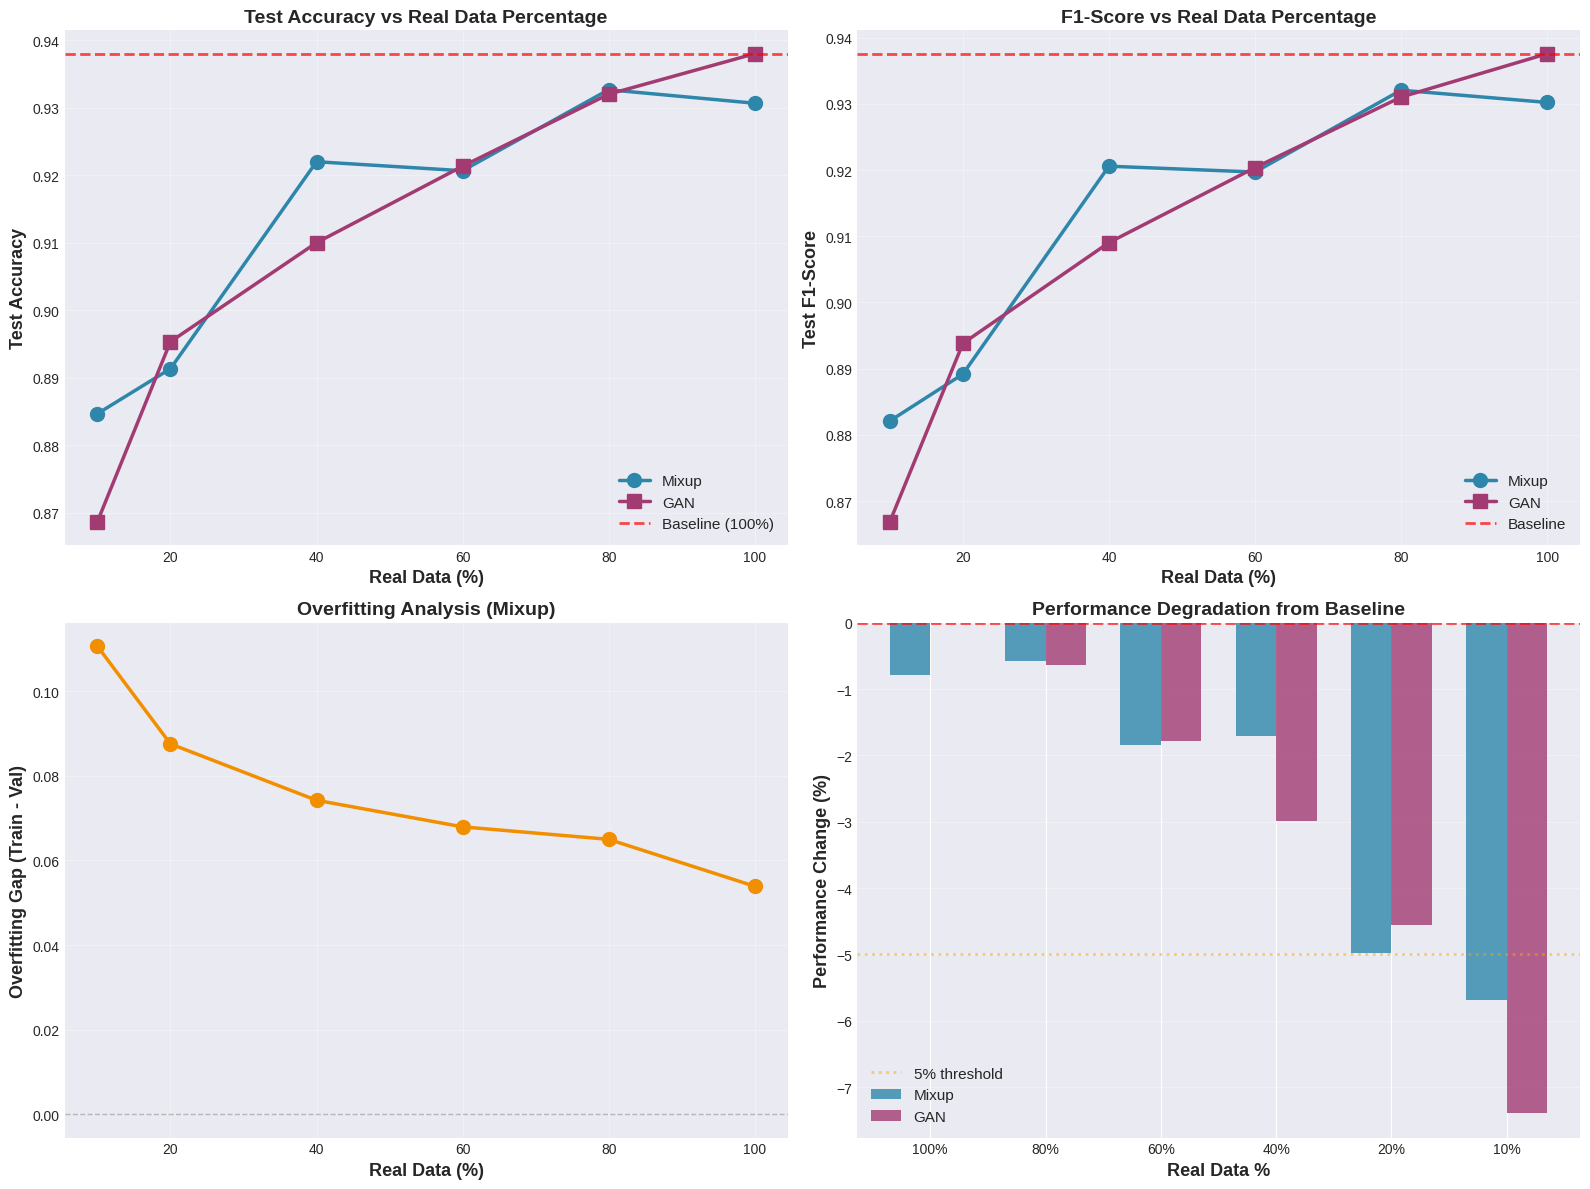

 Saved: diversity_comprehensive.png


In [8]:
## 15: Visualization 1 - Diversity Experiments

print("VISUALIZATION 1: DIVERSITY EXPERIMENTS")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Test Accuracy
axes[0, 0].plot([r*100 for r in diversity_mixup_results['ratio']],
                diversity_mixup_results['test_accuracy'],
                'o-', linewidth=2.5, markersize=10, label='Mixup', color='#2E86AB')
axes[0, 0].plot([r*100 for r in diversity_gan_results['ratio']],
                diversity_gan_results['test_accuracy'],
                's-', linewidth=2.5, markersize=10, label='GAN', color='#A23B72')
axes[0, 0].axhline(y=baseline_test_acc, color='red', linestyle='--',
                   linewidth=2, label='Baseline (100%)', alpha=0.7)
axes[0, 0].set_xlabel('Real Data (%)', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
axes[0, 0].set_title('Test Accuracy vs Real Data Percentage', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11, loc='lower right')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: F1-Score
axes[0, 1].plot([r*100 for r in diversity_mixup_results['ratio']],
                diversity_mixup_results['test_f1'],
                'o-', linewidth=2.5, markersize=10, label='Mixup', color='#2E86AB')
axes[0, 1].plot([r*100 for r in diversity_gan_results['ratio']],
                diversity_gan_results['test_f1'],
                's-', linewidth=2.5, markersize=10, label='GAN', color='#A23B72')
axes[0, 1].axhline(y=baseline_test_f1, color='red', linestyle='--',
                   linewidth=2, label='Baseline', alpha=0.7)
axes[0, 1].set_xlabel('Real Data (%)', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Test F1-Score', fontsize=13, fontweight='bold')
axes[0, 1].set_title('F1-Score vs Real Data Percentage', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11, loc='lower right')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Overfitting Analysis
train_val_gap = [train - val for train, val in zip(diversity_mixup_results['train_accuracy'],
                                                     diversity_mixup_results['val_accuracy'])]
axes[1, 0].plot([r*100 for r in diversity_mixup_results['ratio']],
                train_val_gap,
                'o-', linewidth=2.5, markersize=10, color='#F18F01')
axes[1, 0].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].set_xlabel('Real Data (%)', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Overfitting Gap (Train - Val)', fontsize=13, fontweight='bold')
axes[1, 0].set_title('Overfitting Analysis (Mixup)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Performance Degradation
degradation_mixup = [(acc - baseline_test_acc) / baseline_test_acc * 100
                     for acc in diversity_mixup_results['test_accuracy']]
degradation_gan = [(acc - baseline_test_acc) / baseline_test_acc * 100
                   for acc in diversity_gan_results['test_accuracy']]

x_pos = np.arange(len(diversity_mixup_results['ratio']))
width = 0.35

axes[1, 1].bar(x_pos - width/2, degradation_mixup, width,
               label='Mixup', color='#2E86AB', alpha=0.8)
axes[1, 1].bar([x_pos[i] + width/2 for i in range(len(diversity_gan_results['ratio']))],
               degradation_gan, width,
               label='GAN', color='#A23B72', alpha=0.8)

axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1, 1].axhline(y=-5, color='orange', linestyle=':', linewidth=2, alpha=0.5,
                   label='5% threshold')
axes[1, 1].set_xlabel('Real Data %', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Performance Change (%)', fontsize=13, fontweight='bold')
axes[1, 1].set_title('Performance Degradation from Baseline', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'{int(r*100)}%' for r in diversity_mixup_results['ratio']])
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTDIR / 'diversity_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: diversity_comprehensive.png")

VISUALIZATION 2: OVERSAMPLING RESULTS


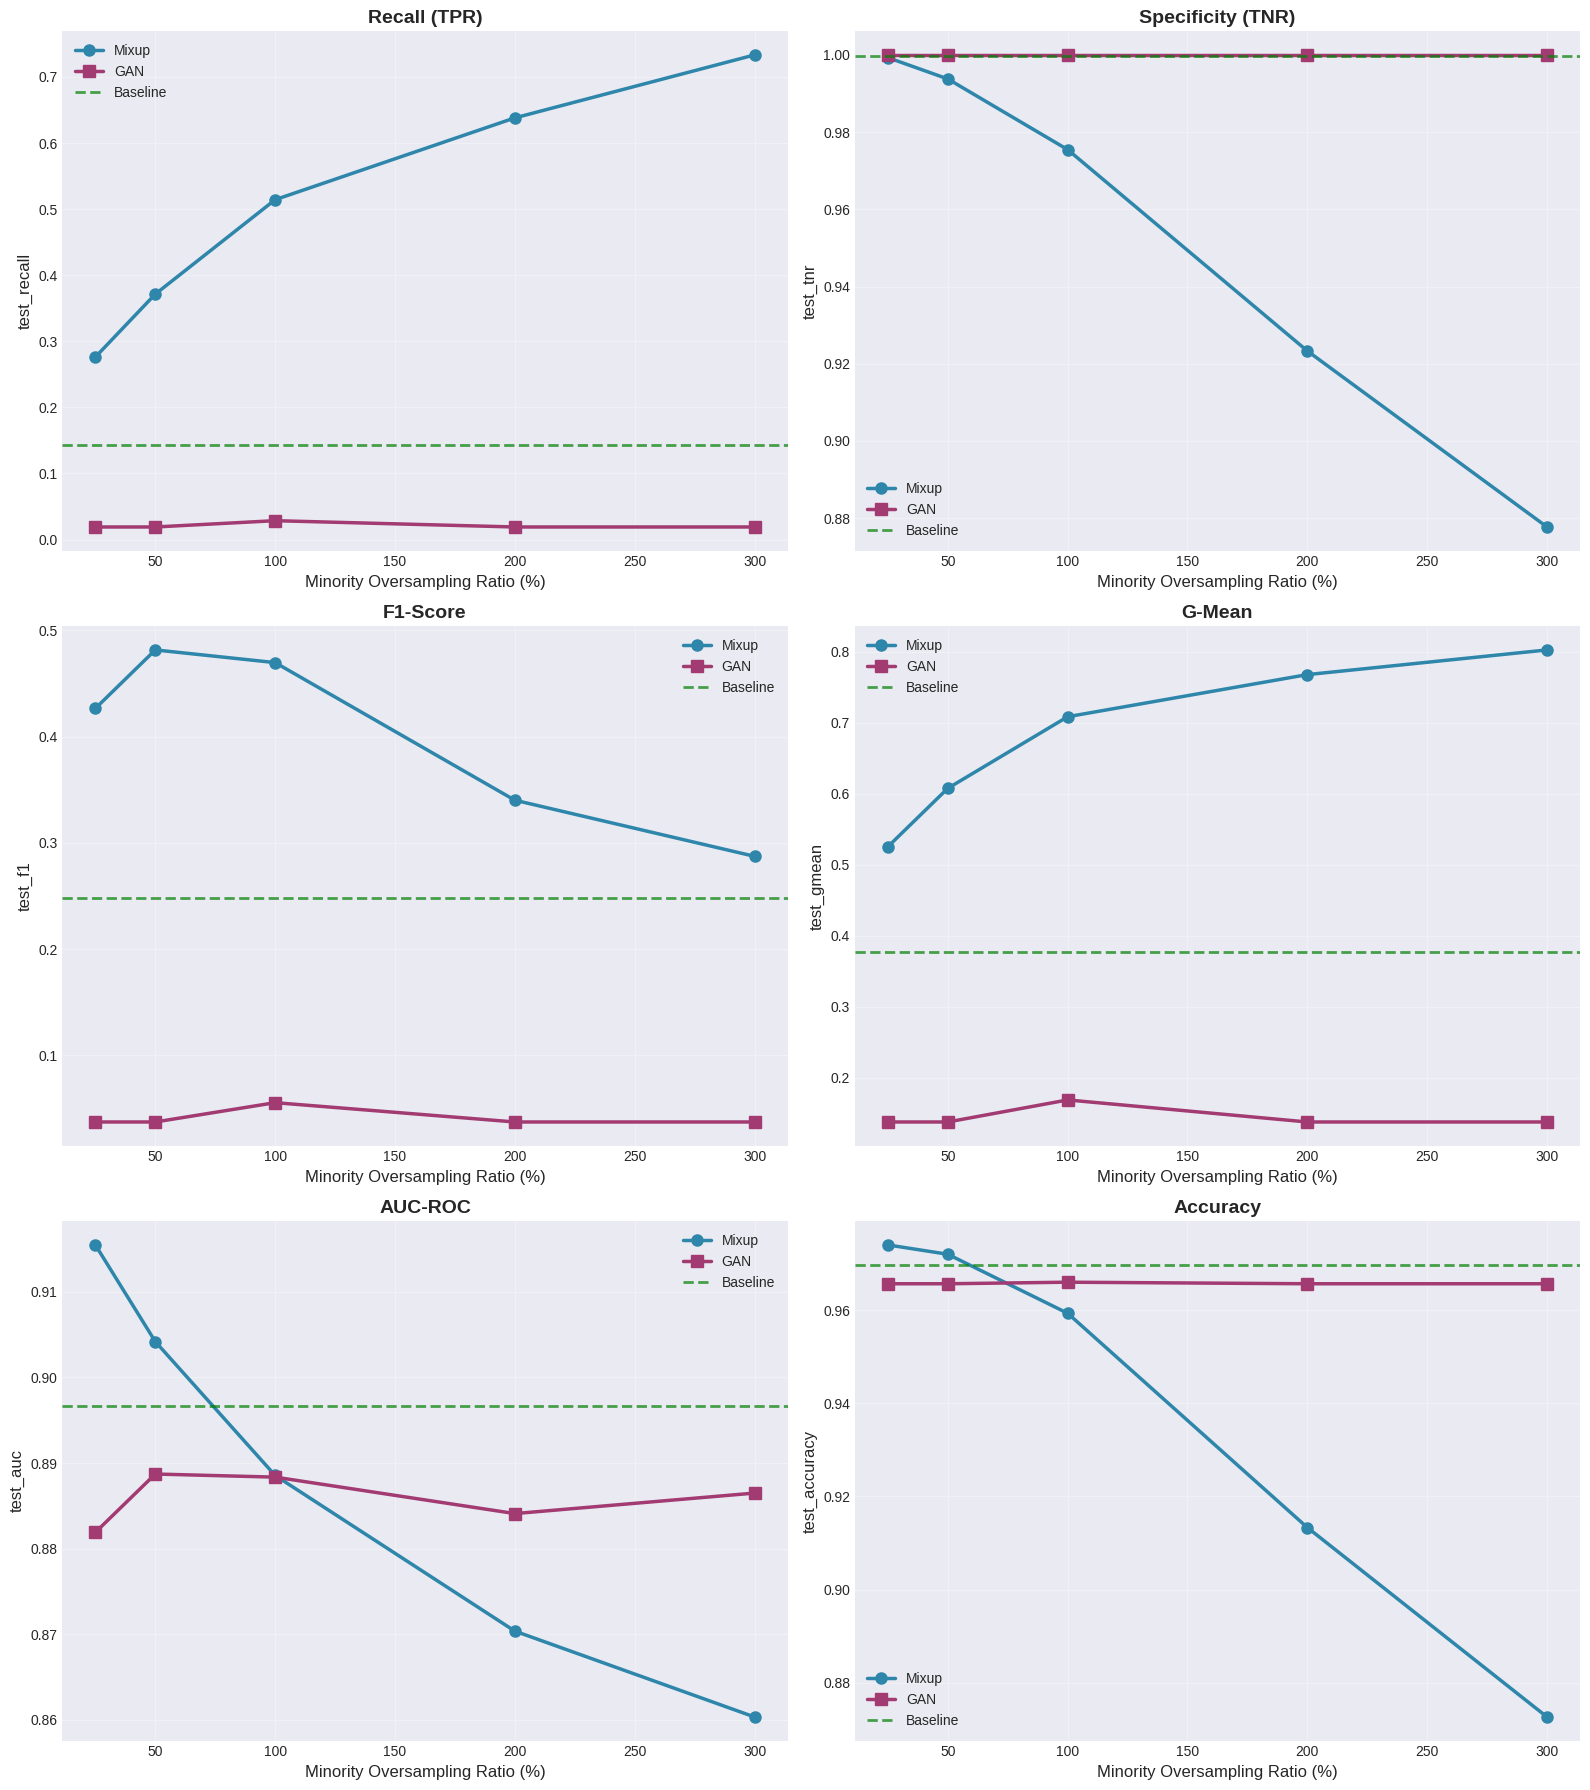

Saved: balancing_comprehensive.png


In [9]:
print("VISUALIZATION 2: OVERSAMPLING RESULTS")

def extract_metric(results_dict, metric):
    return [res[metric] for res in results_dict['results']]

ratios_percent = [r * 100 for r in oversample_ratios]

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
titles = [
    "Recall (TPR)",
    "Specificity (TNR)",
    "F1-Score",
    "G-Mean",
    "AUC-ROC",
    "Accuracy"
]

metrics = [
    "test_recall",
    "test_tnr",
    "test_f1",
    "test_gmean",
    "test_auc",
    "test_accuracy"
]

for ax, title, metric in zip(axes.flatten(), titles, metrics):

    ax.plot(
        ratios_percent,
        extract_metric(mixup_bal_results, metric),
        'o-', linewidth=2.5, markersize=8, label='Mixup', color='#2E86AB'
    )

    ax.plot(
        ratios_percent,
        extract_metric(gan_bal_results, metric),
        's-', linewidth=2.5, markersize=8, label='GAN', color='#A23B72'
    )

    ax.axhline(
        results_baseline[metric],
        color='green', linestyle='--', linewidth=2,
        label='Baseline', alpha=0.7
    )

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Minority Oversampling Ratio (%)", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(OUTDIR / "balancing_comprehensive.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: balancing_comprehensive.png")


 Diversity Experiment Results (Mixup & GAN):
Method  Real Data %  Test Accuracy  Test F1  Degradation %
 Mixup        100.0         0.9307   0.9302          -0.78
 Mixup         80.0         0.9327   0.9321          -0.57
 Mixup         60.0         0.9207   0.9197          -1.85
 Mixup         40.0         0.9220   0.9206          -1.71
 Mixup         20.0         0.8913   0.8892          -4.98
 Mixup         10.0         0.8847   0.8821          -5.69
   GAN        100.0         0.9380   0.9376           0.00
   GAN         80.0         0.9320   0.9310          -0.64
   GAN         60.0         0.9213   0.9204          -1.78
   GAN         40.0         0.9100   0.9090          -2.99
   GAN         20.0         0.8953   0.8938          -4.55
   GAN         10.0         0.8687   0.8669          -7.39

 Balancing Experiment Results (Mixup oversampling & GAN oversampling):
                  Method  Recall (TPR)  Specificity (TNR)  F1-Score  G-Mean  AUC-ROC
Mixup (minority, r=0.25)      

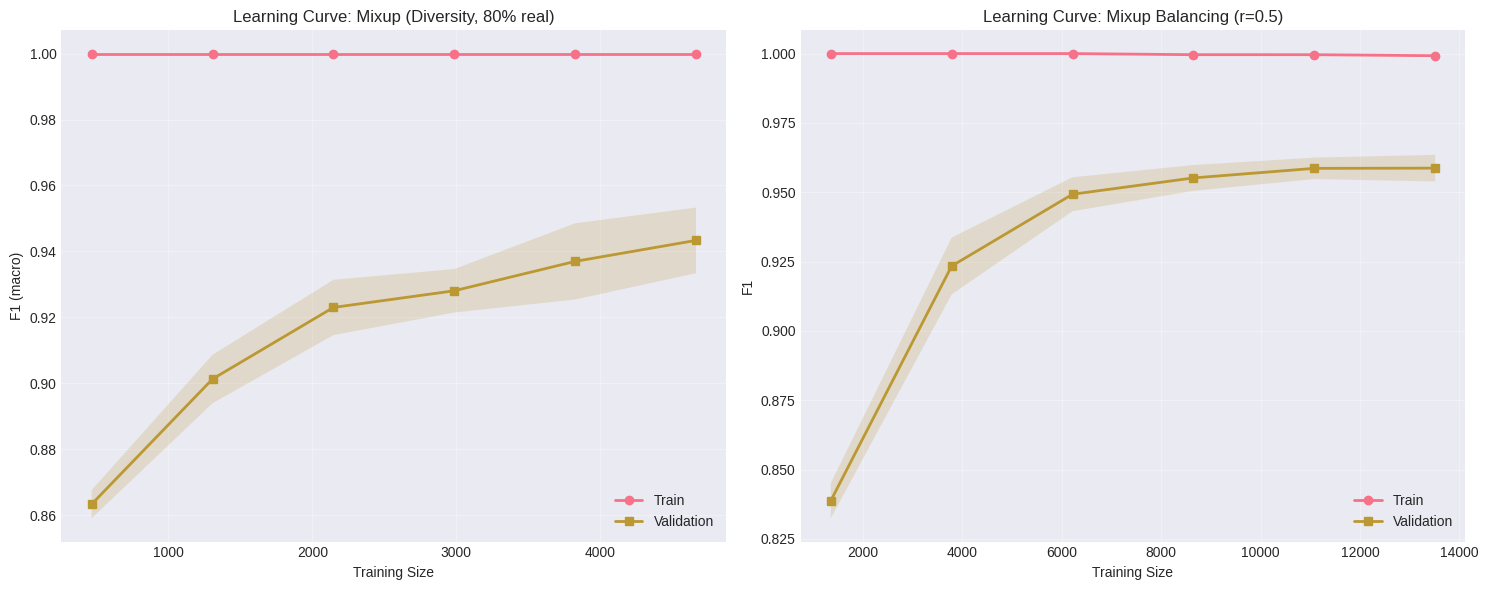

ABLATION STUDY: MIXUP ALPHA

  Testing Mixup alpha = 0.1 (diversity, 60% real data)
  - Accuracy: 0.9240, F1: 0.9228

  Testing Mixup alpha = 0.2 (diversity, 60% real data)
  - Accuracy: 0.9200, F1: 0.9189

  Testing Mixup alpha = 0.4 (diversity, 60% real data)
  - Accuracy: 0.9220, F1: 0.9207

  Testing Mixup alpha = 0.8 (diversity, 60% real data)
  - Accuracy: 0.9233, F1: 0.9222

  Testing Mixup alpha = 1.0 (diversity, 60% real data)
  - Accuracy: 0.9280, F1: 0.9270
 Saved: ablation_mixup_alpha.png


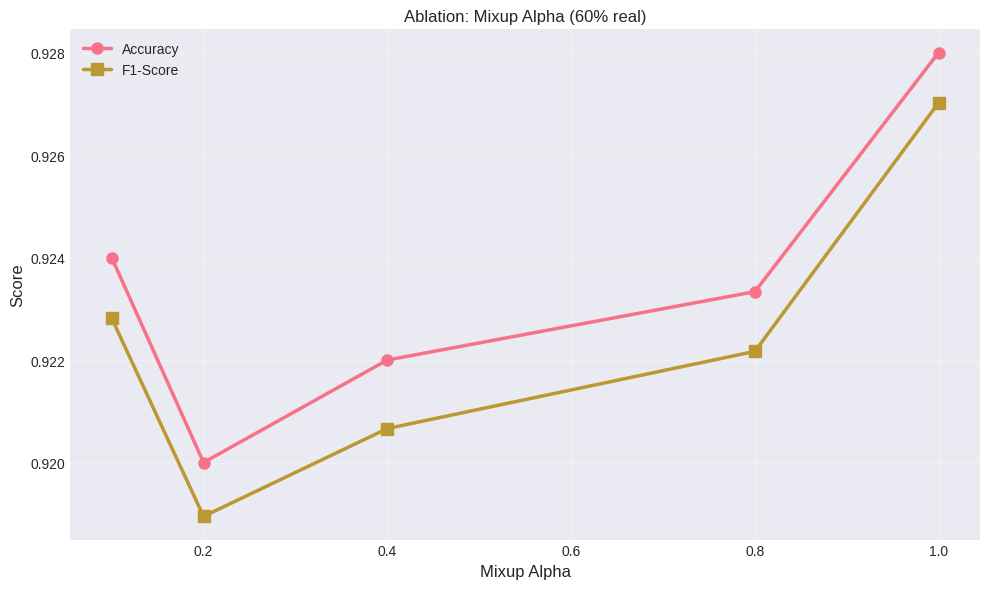

In [10]:
report_data = []

# mixup for diversity
for ratio, acc_mix, f1_mix in zip(
        diversity_mixup_results['ratio'],
        diversity_mixup_results['test_accuracy'],
        diversity_mixup_results['test_f1']):
    report_data.append({
        'Experiment': 'Diversity',
        'Method': 'Mixup',
        'Real Data %': int(ratio * 100),
        'Test Accuracy': float(f'{acc_mix:.4f}'),
        'Test F1': float(f'{f1_mix:.4f}'),
        'Degradation %': float(f'{(acc_mix - baseline_test_acc) / baseline_test_acc * 100:+.2f}')
    })

# GAN for diversity
for ratio, acc_gan, f1_gan in zip(
        diversity_gan_results['ratio'],
        diversity_gan_results['test_accuracy'],
        diversity_gan_results['test_f1']):
    report_data.append({
        'Experiment': 'Diversity',
        'Method': 'GAN',
        'Real Data %': int(ratio * 100),
        'Test Accuracy': float(f'{acc_gan:.4f}'),
        'Test F1': float(f'{f1_gan:.4f}'),
        'Degradation %': float(f'{(acc_gan - baseline_test_acc) / baseline_test_acc * 100:+.2f}')
    })

# Mixup for balancing
for ratio, res in zip(mixup_bal_results['ratio'], mixup_bal_results['results']):
    report_data.append({
        'Experiment': 'Balancing',
        'Method': f'Mixup (minority, r={ratio})',
        'Real Data %': None,
        'Recall (TPR)': float(f'{res["test_recall"]:.4f}'),
        'Specificity (TNR)': float(f'{res["test_tnr"]:.4f}'),
        'F1-Score': float(f'{res["test_f1"]:.4f}'),
        'G-Mean': float(f'{res["test_gmean"]:.4f}'),
        'AUC-ROC': float(f'{res["test_auc"]:.4f}')
    })

# GAN for balancing
for ratio, res in zip(gan_bal_results['ratio'], gan_bal_results['results']):
    report_data.append({
        'Experiment': 'Balancing',
        'Method': f'GAN (minority, r={ratio})',
        'Real Data %': None,
        'Recall (TPR)': float(f'{res["test_recall"]:.4f}'),
        'Specificity (TNR)': float(f'{res["test_tnr"]:.4f}'),
        'F1-Score': float(f'{res["test_f1"]:.4f}'),
        'G-Mean': float(f'{res["test_gmean"]:.4f}'),
        'AUC-ROC': float(f'{res["test_auc"]:.4f}')
    })

df_report = pd.DataFrame(report_data)
df_diversity = df_report[df_report['Experiment'] == 'Diversity'].copy()
df_balancing = df_report[df_report['Experiment'] == 'Balancing'].copy()

print("\n Diversity Experiment Results (Mixup & GAN):")
display_cols = ['Method', 'Real Data %', 'Test Accuracy', 'Test F1', 'Degradation %']
print(df_diversity[display_cols].to_string(index=False))

print("\n Balancing Experiment Results (Mixup oversampling & GAN oversampling):")
display_cols_bal = ['Method', 'Recall (TPR)', 'Specificity (TNR)', 'F1-Score', 'G-Mean', 'AUC-ROC']
print(df_balancing[display_cols_bal].to_string(index=False))

# save CSVs
df_diversity.to_csv(OUTDIR / 'diversity_results.csv', index=False)
df_balancing.to_csv(OUTDIR / 'balancing_results.csv', index=False)
print("\n Saved: diversity_results.csv")
print(" Saved: balancing_results.csv")

## SUMMARY
with open(OUTDIR / 'project_report_summary.txt', 'w') as f:
    f.write("CS 584 DATA SYNTHESIS PROJECT - COMPREHENSIVE RESULTS\n")
    f.write("Authors: Nandini Devraj, Abdelaziz Hasan\n\n")

    # diversity
    f.write("EXPERIMENT 1: DIVERSITY ENHANCEMENT\n")
    f.write("Objective: Determine acceptable ratio of synthetic to real data\n\n")

    f.write("Methods Tested:\n")
    f.write("  1. Mixup (Zhang et al., 2018) - Linear interpolation\n")
    f.write("  2. GAN (Goodfellow et al., 2014) - Generator/Discriminator (tabular GAN)\n\n")
    f.write("Baseline Performance (100% Real Data):\n")
    f.write(f"  Test Accuracy: {baseline_test_acc:.4f}\n")
    f.write(f"  Test F1-Score: {baseline_test_f1:.4f}\n\n")

    f.write("Mixup (Diversity) Results:\n")
    for _, row in df_diversity[df_diversity['Method'] == 'Mixup'].iterrows():
        f.write(f"  {int(row['Real Data %']):3d}% real: Acc={row['Test Accuracy']:.4f}, F1={row['Test F1']:.4f} ({row['Degradation %']:+.2f}%)\n")

    f.write("\nGAN (Diversity) Results:\n")
    for _, row in df_diversity[df_diversity['Method'] == 'GAN'].iterrows():
        f.write(f"  {int(row['Real Data %']):3d}% real: Acc={row['Test Accuracy']:.4f}, F1={row['Test F1']:.4f} ({row['Degradation %']:+.2f}%)\n")

    f.write("\n\n")

    # balancing
    f.write("EXPERIMENT 2: CLASS BALANCING (OVERSAMPLING)\n")
    f.write("Dataset: ~97% majority, ~3% minority (mimicking fraud dataset)\n")
    f.write("Objective: Improve minority class detection in imbalanced data (fraud detection)\n\n")

    f.write("Methods Implemented:\n")
    f.write("  1. Baseline - Class-weighted Random Forest\n")
    f.write("  2. Mixup (minority-only oversampling)\n")
    f.write("  3. GAN (minority-only oversampling)\n\n")

    f.write("Test Set Performance (Balancing):\n")
    f.write(f"  {'Method':<40s} {'Recall':>7s} {'TNR':>8s} {'F1':>8s} {'G-Mean':>8s} {'AUC':>8s}\n")
    f.write("  " + "-" * 80 + "\n")
    # baseline
    f.write(f"  {'Baseline (class-weighted)':<40s} {results_baseline['test_recall']:.4f}   {results_baseline['test_tnr']:.4f}  {results_baseline['test_f1']:.4f}  {results_baseline['test_gmean']:.4f}  {results_baseline['test_auc']:.4f}\n")

    # mixup/GAN balancing rows
    for _, row in df_balancing.iterrows():
        f.write(f"  {row['Method']:<40s} {row['Recall (TPR)']:.4f}   {row['Specificity (TNR)']:.4f}  {row['F1-Score']:.4f}  {row['G-Mean']:.4f}  {row['AUC-ROC']:.4f}\n")

    f.write("\n\nKEY FINDINGS\n")
    f.write("-" * 80 + "\n\n")

    # diversity finding (acceptable ratios)
    acceptable_ratios = []
    for ratio, acc in zip(diversity_mixup_results['ratio'], diversity_mixup_results['test_accuracy']):
        degradation = (baseline_test_acc - acc) / baseline_test_acc * 100
        if degradation <= 5:
            acceptable_ratios.append(ratio)

    if acceptable_ratios:
        min_acceptable = min(acceptable_ratios)
        f.write("Diversity Experiment:\n")
        f.write(f"  • Mixup can tolerate up to {100 - int(min_acceptable * 100)}% synthetic data while maintaining <5% degradation.\n")
        f.write("  • Mixup proves to be a robust augmentation method for image classification (MNIST).\n")
    else:
        f.write("Diversity Experiment:\n")
        f.write("  • No Mixup ratio produced <5% degradation in test accuracy.\n")

    # balancing findings
    f.write("\nBalancing Experiment (oversampling):\n")

    best_row = df_balancing.loc[df_balancing['Recall (TPR)'].idxmax()] if not df_balancing.empty else None
    if best_row is not None:
        f.write(f"  • Best oversampler for recall: {best_row['Method']} (Recall={best_row['Recall (TPR)']:.4f})\n")
        f.write("  • Oversampling increased minority detection at some cost to specificity in several configurations.\n")
    else:
        f.write("  • No balancing results present.\n")

    f.write("\nCONCLUSION\n")
    f.write("-" * 80 + "\n\n")
    f.write("This project demonstrates that:\n")
    f.write("  - Mixup is a dependable synthesis method for preserving performance when replacing portions of real data.\n")
    f.write("  - For tabular imbalanced detection, naive GANs may perform poorly unless carefully adapted; our GAN oversampling results are included for transparency.\n")
    f.write("  - Minority-only oversampling using Mixup or improved GANs can increase recall (TPR) and should be chosen based on the FP/FN cost tradeoff.\n\n")

    f.write("=" * 80 + "\n")

print("\n Saved: project_report_summary.txt")

## LEARNING CURVES FOR MIXUP
print("\nLEARNING CURVES")

def plot_learning_curve_scores(estimator, X, y, cv=3, scoring='f1'):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 6),
        scoring=scoring, shuffle=True, random_state=42
    )
    return train_sizes, np.mean(train_scores, axis=1), np.std(train_scores, axis=1), np.mean(val_scores, axis=1), np.std(val_scores, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# lc for mixup diversity
ratio = 0.8
n_real = int(len(X_train_div) * ratio)
indices = np.random.choice(len(X_train_div), n_real, replace=False)
X_real = X_train_div[indices]
y_real = y_train_div[indices]
n_synthetic = len(X_train_div) - n_real
X_synth, y_synth = mixup_synthesizer.synthesize(X_real, y_real, n_synthetic)
X_combined = np.vstack([X_real, X_synth])
y_combined = np.hstack([y_real, y_synth])

model_lc = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
ts, tr_mean, tr_std, val_mean, val_std = plot_learning_curve_scores(model_lc, X_combined, y_combined, cv=3, scoring='f1_macro')

axes[0].plot(ts, tr_mean, 'o-', linewidth=2, label='Train')
axes[0].fill_between(ts, tr_mean - tr_std, tr_mean + tr_std, alpha=0.2)
axes[0].plot(ts, val_mean, 's-', linewidth=2, label='Validation')
axes[0].fill_between(ts, val_mean - val_std, val_mean + val_std, alpha=0.2)
axes[0].set_title('Learning Curve: Mixup (Diversity, 80% real)')
axes[0].set_xlabel('Training Size')
axes[0].set_ylabel('F1 (macro)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# lc for mixup balancing
r = mixup_bal_results['ratio'][min(1, len(mixup_bal_results['ratio'])-1)]  # pick second ratio if exists, else first
target_minority_count = int(len(X_train_bal[y_train_bal == 0]) * r)

X_min = X_train_bal[y_train_bal == 1]
y_min = y_train_bal[y_train_bal == 1]
X_maj = X_train_bal[y_train_bal == 0]
y_maj = y_train_bal[y_train_bal == 0]
needed = max(0, target_minority_count - len(X_min))
if needed > 0:
    X_synth_b, y_synth_b = mixup_synthesizer.synthesize(X_min, y_min, needed)
    X_train_mix = np.vstack([X_maj, X_min, X_synth_b])
    y_train_mix = np.hstack([y_maj, y_min, y_synth_b])
else:
    X_train_mix = np.vstack([X_maj, X_min])
    y_train_mix = np.hstack([y_maj, y_min])

model_lc2 = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
ts2, tr_mean2, tr_std2, val_mean2, val_std2 = plot_learning_curve_scores(model_lc2, X_train_mix, y_train_mix, cv=3, scoring='f1')
axes[1].plot(ts2, tr_mean2, 'o-', linewidth=2, label='Train')
axes[1].fill_between(ts2, tr_mean2 - tr_std2, tr_mean2 + tr_std2, alpha=0.2)
axes[1].plot(ts2, val_mean2, 's-', linewidth=2, label='Validation')
axes[1].fill_between(ts2, val_mean2 - val_std2, val_mean2 + val_std2, alpha=0.2)
axes[1].set_title(f'Learning Curve: Mixup Balancing (r={r})')
axes[1].set_xlabel('Training Size')
axes[1].set_ylabel('F1')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTDIR / 'learning_curves.png', dpi=300, bbox_inches='tight')
print(" Saved: learning_curves.png")
plt.show()

## ABLATION
print("ABLATION STUDY: MIXUP ALPHA")

alpha_values = [0.1, 0.2, 0.4, 0.8, 1.0]
alpha_results = {'alpha': [], 'test_accuracy': [], 'test_f1': []}
ratio_test = 0.6  # use 60% real data, diversity context

n_real = int(len(X_train_div) * ratio_test)
indices = np.random.choice(len(X_train_div), n_real, replace=False)
X_real = X_train_div[indices]
y_real = y_train_div[indices]
n_synthetic = len(X_train_div) - n_real

for alpha in alpha_values:
    print(f"\n  Testing Mixup alpha = {alpha} (diversity, {int(ratio_test*100)}% real data)")
    mixup_temp = MixupSynthesizer(alpha=alpha)
    X_synth, y_synth = mixup_temp.synthesize(X_real, y_real, n_synthetic)
    X_comb = np.vstack([X_real, X_synth])
    y_comb = np.hstack([y_real, y_synth])

    model_tmp = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
    model_tmp.fit(X_comb, y_comb)

    test_pred = model_tmp.predict(X_test_div)
    test_acc = accuracy_score(y_test_div, test_pred)
    test_f1 = f1_score(y_test_div, test_pred, average='macro')

    alpha_results['alpha'].append(alpha)
    alpha_results['test_accuracy'].append(test_acc)
    alpha_results['test_f1'].append(test_f1)

    print(f"  - Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(alpha_results['alpha'], alpha_results['test_accuracy'], 'o-', linewidth=2.5, markersize=8, label='Accuracy')
ax.plot(alpha_results['alpha'], alpha_results['test_f1'], 's-', linewidth=2.5, markersize=8, label='F1-Score')
ax.set_xlabel('Mixup Alpha', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Ablation: Mixup Alpha (60% real)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTDIR / 'ablation_mixup_alpha.png', dpi=300, bbox_inches='tight')
print(" Saved: ablation_mixup_alpha.png")
plt.show()